In [7]:
%pip install nltk
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install gradio


In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from string import punctuation
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /Users/guna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/guna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/guna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/guna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
input_df = pd.read_csv('Dataset/train.csv')

In [10]:
input_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [11]:
%%capture
def data_cleanup(train_df):
    train_df['text'] = train_df['text'].str.lower()
    train_df['text'] = train_df['text'].str.strip()
    train_df['text'] = train_df['text'].replace(to_replace ='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='\?*', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='(RT|rt)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='@[a-z,_]*', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='([0-9]*:[0-9]*)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='([0-9]*\.[0-9]*)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='(utc|gmt)', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='_[\S]', value = '', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='&amp;?', value = 'and', regex = False)
    train_df['text'] = train_df['text'].replace(to_replace ='&lt;', value = '<', regex = False)
    train_df['text'] = train_df['text'].replace(to_replace ='&gt;', value = '>', regex = False)
    train_df['text'] = train_df['text'].replace(to_replace ='[ ]{2, }', value = ' ', regex = True)
    train_df['text'] = train_df['text'].replace(to_replace ='([^\w\d ]+)', value = '', regex = True)
    return train_df['text']

In [12]:
%%capture
# train_df = pd.read_csv('Dataset/train.csv')
input_df['text'] = data_cleanup(input_df)

In [13]:
input_df

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this eahquake may ...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,the out of control wild fires in california ...,1
7610,10871,NaN,NaN,m 5km s of volcano hawaii,1
7611,10872,NaN,NaN,police investigating after an ebike collided w...,1


In [14]:
#Training and Test Dataset split
tweet_texts = input_df['text']
class_labels = input_df['target']
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweet_texts,class_labels,test_size=0.2, random_state=42, stratify=class_labels)

In [15]:
#Concat tweets and labels series from the split into dataframe
train_cols = [pd.Series(train_tweets, name='text'), pd.Series(train_labels, name='labels')]
train_df = pd.concat(train_cols, axis = 1)
test_cols = [pd.Series(test_tweets, name='text'), pd.Series(test_labels, name='labels')]
test_df = pd.concat(test_cols,axis = 1)

In [16]:
#Text Preprocessor
def preprocessing(text):
   word_lemma = []
   tweet_tokenize = TweetTokenizer()
   tokens = tweet_tokenize.tokenize((text).lower())
   tokens = [w for w in tokens if w not in punctuation and not w.isdigit() and not len(w) < 3]
   stop_words = stopwords.words ('english')
   tweet_without_stopwords = [t for t in tokens if t not in stop_words]
   text = " ".join (tweet_without_stopwords)
   word_lemma = [WordNetLemmatizer().lemmatize(t) for t in tweet_tokenize.tokenize(text)]
   pp_text = " ".join (word_lemma)
   return pp_text

In [17]:
def get_performance_score(actual_label : list, predicted_label : list):
    '''Function to calculate the performance metric using sklearn.
    
    Parameters
    ----------
    actual_label : list
      Actual(Ground Truth) class label from the dataset.
    predicted_label : pd.DataFrame
      Class label predicted by the model
    
    Return
    ------
    f1_score : float
    accuracy : float
    precision : float
    recall : float
    AUROC : float
    '''
    precision = metrics.precision_score(actual_label, predicted_label, pos_label=1)
    recall = metrics.recall_score(actual_label, predicted_label,pos_label=1)
    AUROC = metrics.roc_auc_score(actual_label, predicted_label)
    accuracy = metrics.accuracy_score(actual_label, predicted_label)
    f1_score = metrics.f1_score(actual_label, predicted_label,pos_label=1)
    confusion_mat = metrics.confusion_matrix(actual_label, predicted_label)
    metrics_list = [f1_score, accuracy, precision, recall, AUROC]
    metrics_list = pd.DataFrame(metrics_list).T
    metrics_df = metrics_list.rename(columns={0:'F1',1:'Accuracy',2:'Precision',3:'Recall',4:'AUROC'})
    return metrics_df, confusion_mat

In [18]:
def plot_confusion_matrix(confusion_mat, model_name):
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels=['not_disaster','disaster'])
    title = model_name + " Confusion Matrix"
    cm_plot.plot(cmap=plt.cm.Greens)
    plt.title(title)
    plt.show()


## Variable definitions
 - train_tweets - Preprocessed tweets for training
 - test_tweets - Preprocessed tweets for testing
 - train_labels - class label for training tweets
 - test_labels - class label for test tweets

## Baseline
1. Implement traditional model(MultinomialNB, LogisticRegression, SVC, KNeighborsClassifier) from sklearn
2. Train and test the default model without tuning hyperparameter values
3. Use grid search(GridSearchCV) from sklearn to identify best values for hyperparameters
4. Train the model with best hypermeter values and test it on test set(test_tweets)

## Traditional Classifiers

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [20]:
vectorizer = CountVectorizer(preprocessor=preprocessing,ngram_range = (1,2))
vectors_train = vectorizer.fit_transform(train_df['text'])
vectors_test = vectorizer.transform(test_df['text'])
train_labels = train_df['labels']
test_labels = test_df['labels']

In [21]:
def cv_grid_search(model, param_grid, cv, scoring, train_tweet, train_label):
  '''Function to perform grid search.

    Parameters
    ----------
    model : Object
    norm : str
    param_grid : list
    cv : int
    scoring : str
    
    Return
    ------
    grid_search : Object
    '''
  grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=True, error_score = True)
  grid_search.fit(train_tweet, train_label)
  return grid_search

In [22]:
def consolidate_perf_score(models_list, perf_score_list):
  '''Function to consolidate the performance metrics of all the models(KNeighborsClassifier, RandomForestClassifier, LogisticRegression, MLPClassifier) 
  and return a pd.DataFrame.

    Parameters
    ----------
    models_list : list
      List of models.
    perf_score_list : list
      List of performance metrics data frame from various models.
      
    Return
    ------
    consolidated_metrics_df : pd.DataFrame
    '''
  
  consolidated_perf_score_df = pd.concat(perf_score_list)
  consolidated_perf_score_df = consolidated_perf_score_df.rename(columns={0:'F1',1:'Accuracy',2:'Precision',3:'Recall'})
  consolidated_perf_score_df.insert(0,'Model',models_list)
  return consolidated_perf_score_df

In [23]:
def initialize_trad_models():
    '''Function to initialize the traditional models from sklearn.

    Return
    ------
    nb : Object
    knc : Object
    lr : Object
    svc : Object
    '''
    nb = MultinomialNB()
    knc = KNeighborsClassifier()
    lr = LogisticRegression()
    svc = SVC()
    return nb, knc,lr, svc

In [24]:
nb, knc, lr, svc = initialize_trad_models()

In [25]:
%%capture
param_grid = {
      'alpha': (0.01,0.2,0.4,1.0),
      'fit_prior': (True,False)}
nb_gs = cv_grid_search(nb, param_grid, 10, 'f1', vectors_train, train_labels)

In [26]:
param_grid = [{'n_neighbors': [3, 5, 10, 12],
               'p': [1, 2],
               'weights':['uniform', 'distance'],
               'algorithm': ['auto', 'brute']}]
knc_gs = cv_grid_search(knc, param_grid, 10, 'f1', vectors_train, train_labels)

In [30]:
param_grid = [
    {'penalty': ['l2'],
     'tol': [1e-3, 1e-4],
     'solver':['lbfgs', 'liblinear'],
     'max_iter': [1000, 5000, 10000],
     'random_state': [42]}
  ]
lr_gs = cv_grid_search(lr, param_grid, 10, 'f1', vectors_train, train_labels)

In [31]:
param_grid = [
    {'kernel': ['poly', 'sigmoid', 'rbf'],
     'gamma' : ['scale', 'auto'],
     'random_state': [42]}
  ]
svc_gs = cv_grid_search(svc, param_grid, 10, 'f1', vectors_train, train_labels)

In [32]:
best_nb, best_knc, best_lr, best_svc = initialize_trad_models()

In [33]:
#Set the best parameter values for each model from grid search for the hyperparameters 
best_nb.set_params(**nb_gs.best_params_)
best_knc.set_params(**knc_gs.best_params_)
best_lr.set_params(**lr_gs.best_params_)
best_svc.set_params(**svc_gs.best_params_)

#Train the each model with the best parameters
best_nb.fit(vectors_train,train_labels)
best_knc.fit(vectors_train,train_labels)
best_lr.fit(vectors_train,train_labels)
best_svc.fit(vectors_train,train_labels)

#Predict the labels on test dataset using the trained models
nb_predict = best_nb.predict(vectors_test)
knc_predict = best_knc.predict(vectors_test)
lr_predict = best_lr.predict(vectors_test)
svc_predict = best_svc.predict(vectors_test)
nb_predicted_labels = np.array(nb_predict, dtype = int)
knc_predicted_labels = np.array(knc_predict, dtype = int)
lr_predictted_labels = np.array(lr_predict, dtype = int)
svc_predicted_labels = np.array(svc_predict, dtype = int)
actual_labels = np.array(test_labels, dtype = int)

#Calculate the performance metrics based on the predicted labels and actual labels in test dataset
nb_perf_scores, nb_cm = get_performance_score(nb_predicted_labels, actual_labels)
knc_perf_scores, knc_cm = get_performance_score(knc_predicted_labels, actual_labels)
lr_perf_scores, lr_cm = get_performance_score(lr_predictted_labels, actual_labels)
svc_perf_scores, svc_cm = get_performance_score(svc_predicted_labels, actual_labels)


In [34]:
consolidate_perf_score(['nb', 'knc', 'lr', 'svc'], [nb_perf_scores, knc_perf_scores, lr_perf_scores, svc_perf_scores])

,Model,F1,Accuracy,Precision,Recall,AUROC
0,nb,0.766400,0.808273,0.732416,0.803691,0.807455
0,knc,0.621535,0.533815,0.891437,0.477087,0.620603
0,lr,0.773289,0.819435,0.717125,0.838998,0.823545
0,svc,0.761578,0.817466,0.678899,0.867188,0.829736


## BERTweet

In [35]:
!pip install transformers
!pip install torch
!pip install datasets
!pip install evaluate
!pip install numpy
!pip install accelerate
!pip install emoji==0.6.0
!pip install torch torchvision torchaudio

In [36]:
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import BertweetTokenizer
from transformers import AlbertTokenizer, AlbertModel
from transformers import AutoModel
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import TrainingArguments, Trainer
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from transformers import AutoConfig
from sklearn import metrics

/Users/guna/anaconda3/envs/detect-disaster/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
for index, row in input_df.iterrows():
        text = row['text']
        pp_text = preprocessing(text)
        input_df.at[index, 'text'] = pp_text

In [38]:
#Training and Test Dataset split
tweet_texts = input_df['text']
class_labels = input_df['target']
train_tweets, test_tweets, train_labels, test_labels = train_test_split(tweet_texts,class_labels,test_size=0.2, random_state=42, stratify=class_labels)

In [39]:
##raining and Dev Dataset split
tweet_texts = train_tweets
class_labels = train_labels
train_tweets, dev_tweets, train_labels, dev_labels = train_test_split(tweet_texts,class_labels,test_size=0.2, random_state=42, stratify=class_labels)

In [40]:
#Concat tweets and labels series from the split into dataframe
train_cols = [pd.Series(train_tweets, name='text'), pd.Series(train_labels, name='labels')]
train_df = pd.concat(train_cols, axis = 1)
dev_cols = [pd.Series(dev_tweets, name='text'), pd.Series(dev_labels, name='labels')]
dev_df = pd.concat(dev_cols, axis = 1)
test_cols = [pd.Series(test_tweets, name='text'), pd.Series(test_labels, name='labels')]
test_df = pd.concat(test_cols,axis = 1)

In [41]:
#Define constants for BERTweet model
model_name = "vinai/bertweet-base"
max_length = 32
trucate = True
padding='max_length'
batch_size = 32
mps_device = torch.device("mps")
id2text = {0: "not_disaster", 1: "disaster"}
text2id = {"not_disaster": 0, "disaster": 1}

In [ ]:
#Intialize tokenizer, data_collector and classifier for BERTweet
tokenizer = BertweetTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2text, label2id=text2id)
classifier = classifier.to(mps_device)

In [43]:
def preprocessor(input):
     token_ids_dict = tokenizer.encode_plus(input['text'], add_special_tokens = True, padding=padding, max_length=max_length, truncation=trucate,return_attention_mask = True)
     token_ids_dict['label'] = input['labels']
     return token_ids_dict

In [44]:
#Convert the input text into token_ids, attention_mask and token_type_ids dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)
train_map = train_dataset.map(preprocessor)
dev_map = eval_dataset.map(preprocessor)
test_map = test_dataset.map(preprocessor)

Map: 100%|██████████| 1523/1523 [00:00<00:00, 6581.11 examples/s]


In [45]:
def calculate_f1(labels):
    f1 = evaluate.load("f1")
    predicted, actual = labels
    predicted = np.argmax(predicted, axis=1)
    return f1.compute(predictions=predicted, references=actual)

In [46]:
#Intialize Trainer and Training Arguments for finetuning BERTweet
training_args = TrainingArguments(
    output_dir="trainer_cache",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model = 'f1',
    greater_is_better=True,
    num_train_epochs=8,
    learning_rate = 1e-5,
    adam_epsilon = 1e-5,
    weight_decay = 1e-5,
    adafactor = False,
    use_mps_device=True

)

bt_trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=train_map,
    eval_dataset=dev_map,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=calculate_f1,
)

/Users/guna/anaconda3/envs/detect-disaster/lib/python3.12/site-packages/transformers/training_args.py:2046: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [47]:
#Finetune BERTweet
bt_trainer.train()

 10%|█         | 501/4872 [01:23<12:55,  5.64it/s]

{'loss': 0.5094, 'grad_norm': 7.860188007354736, 'learning_rate': 8.973727422003284e-06, 'epoch': 0.82}


                                                  
 12%|█▎        | 609/4872 [01:51<12:00,  5.92it/s]

{'eval_loss': 0.44314536452293396, 'eval_f1': 0.7948969578017664, 'eval_runtime': 10.0256, 'eval_samples_per_second': 121.489, 'eval_steps_per_second': 15.261, 'epoch': 1.0}


 21%|██        | 1001/4872 [02:57<10:20,  6.24it/s] 

{'loss': 0.4403, 'grad_norm': 4.672109127044678, 'learning_rate': 7.947454844006569e-06, 'epoch': 1.64}


                                                   
 25%|██▌       | 1218/4872 [03:40<09:55,  6.13it/s]

{'eval_loss': 0.44206660985946655, 'eval_f1': 0.7943661971830986, 'eval_runtime': 7.6634, 'eval_samples_per_second': 158.938, 'eval_steps_per_second': 19.965, 'epoch': 2.0}


 31%|███       | 1501/4872 [04:30<08:56,  6.29it/s]  

{'loss': 0.3935, 'grad_norm': 0.995601236820221, 'learning_rate': 6.9211822660098524e-06, 'epoch': 2.46}


                                                   
 38%|███▊      | 1827/4872 [05:27<08:03,  6.30it/s]

{'eval_loss': 0.4710157811641693, 'eval_f1': 0.80078125, 'eval_runtime': 4.8908, 'eval_samples_per_second': 249.038, 'eval_steps_per_second': 31.283, 'epoch': 3.0}


 41%|████      | 2001/4872 [05:57<07:43,  6.19it/s]  

{'loss': 0.3803, 'grad_norm': 2.9360480308532715, 'learning_rate': 5.894909688013136e-06, 'epoch': 3.28}


                                                   
 50%|█████     | 2436/4872 [07:14<06:31,  6.22it/s]

{'eval_loss': 0.6383756399154663, 'eval_f1': 0.7874885004599816, 'eval_runtime': 7.6127, 'eval_samples_per_second': 159.996, 'eval_steps_per_second': 20.098, 'epoch': 4.0}


 51%|█████▏    | 2501/4872 [07:27<06:31,  6.06it/s]  

{'loss': 0.3307, 'grad_norm': 0.3407818675041199, 'learning_rate': 4.868637110016421e-06, 'epoch': 4.11}


 62%|██████▏   | 3001/4872 [08:50<05:10,  6.03it/s]

{'loss': 0.3177, 'grad_norm': 25.193965911865234, 'learning_rate': 3.842364532019705e-06, 'epoch': 4.93}


                                                   
 62%|██████▎   | 3045/4872 [09:05<04:52,  6.24it/s]

{'eval_loss': 0.7009804248809814, 'eval_f1': 0.7930082796688133, 'eval_runtime': 7.5284, 'eval_samples_per_second': 161.788, 'eval_steps_per_second': 20.323, 'epoch': 5.0}


 72%|███████▏  | 3501/4872 [10:23<03:39,  6.26it/s]  

{'loss': 0.2746, 'grad_norm': 1.755327820777893, 'learning_rate': 2.8160919540229887e-06, 'epoch': 5.75}


                                                   
 75%|███████▌  | 3654/4872 [10:55<03:12,  6.32it/s]

{'eval_loss': 0.7118059396743774, 'eval_f1': 0.7962264150943397, 'eval_runtime': 7.4969, 'eval_samples_per_second': 162.468, 'eval_steps_per_second': 20.409, 'epoch': 6.0}


 82%|████████▏ | 4001/4872 [11:54<02:18,  6.28it/s]  

{'loss': 0.262, 'grad_norm': 8.58166217803955, 'learning_rate': 1.7898193760262728e-06, 'epoch': 6.57}


                                                   
 88%|████████▊ | 4263/4872 [12:44<01:42,  5.94it/s]

{'eval_loss': 0.782924234867096, 'eval_f1': 0.786308973172988, 'eval_runtime': 5.0964, 'eval_samples_per_second': 238.993, 'eval_steps_per_second': 30.021, 'epoch': 7.0}


 92%|█████████▏| 4501/4872 [13:26<00:59,  6.26it/s]

{'loss': 0.2283, 'grad_norm': 0.24771034717559814, 'learning_rate': 7.635467980295568e-07, 'epoch': 7.39}


                                                   
100%|██████████| 4872/4872 [14:31<00:00,  6.15it/s]

{'eval_loss': 0.7893021106719971, 'eval_f1': 0.788785046728972, 'eval_runtime': 5.4195, 'eval_samples_per_second': 224.743, 'eval_steps_per_second': 28.231, 'epoch': 8.0}


100%|██████████| 4872/4872 [14:35<00:00,  5.56it/s]

{'train_runtime': 875.6433, 'train_samples_per_second': 44.511, 'train_steps_per_second': 5.564, 'train_loss': 0.3415023806842873, 'epoch': 8.0}


TrainOutput(global_step=4872, training_loss=0.3415023806842873, metrics={'train_runtime': 875.6433, 'train_samples_per_second': 44.511, 'train_steps_per_second': 5.564, 'total_flos': 640938530856960.0, 'train_loss': 0.3415023806842873, 'epoch': 8.0})

In [68]:
actual_label = test_df['labels']
predictions_prob = bt_trainer.predict(test_map)
predictions =  predictions_prob.predictions
predictions = np.argmax(predictions,axis=1)
predicted_lables = np.array(predictions, dtype = int)
actual_labels = np.array(actual_label, dtype = int)
metrics_df, confusion_mat = get_performance_score(actual_labels, predicted_lables)

100%|██████████| 191/191 [00:08<00:00, 22.84it/s]


In [ ]:
metrics_df, confusion_mat

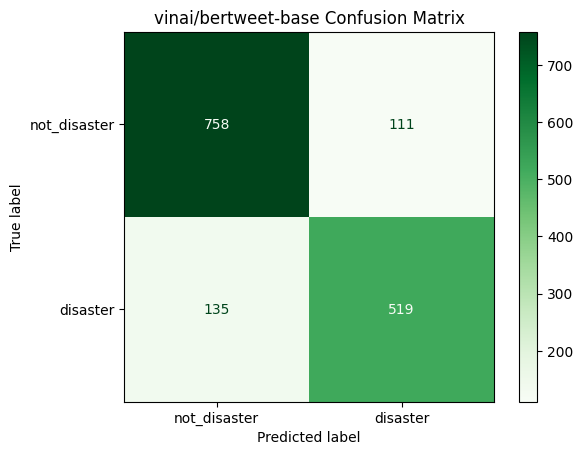

In [49]:
plot_confusion_matrix(confusion_mat, model_name)

In [50]:
bt_trainer.save_model(output_dir = 'model/bertweet/v1/')

## RoBERTa

In [51]:
model_name = "FacebookAI/xlm-roberta-base"
max_length = 32
trucate = True
padding='max_length'
id2text = {0: "not_disaster", 1: "disaster"}
text2id = {"not_disaster": 0, "disaster": 1}
classifier = classifier.to(mps_device)

In [52]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
classifier = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, id2label=id2text, label2id=text2id)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
def preprocessor(input):
     token_ids_dict = tokenizer.encode_plus(input['text'], add_special_tokens = True, padding=padding, max_length=max_length, truncation=trucate,return_attention_mask = True)
     token_ids_dict['label'] = input['labels']
     return token_ids_dict

In [54]:
#Convert the input text into token_ids, attention_mask and token_type_ids dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)
train_map = train_dataset.map(preprocessor)
dev_map = eval_dataset.map(preprocessor)
test_map = test_dataset.map(preprocessor)

Map: 100%|██████████| 1523/1523 [00:00<00:00, 8934.55 examples/s]


In [55]:
training_args = TrainingArguments(
    output_dir="trainer_cache",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model = 'f1',
    greater_is_better=True,
    num_train_epochs=8,
    learning_rate = 1e-5,
    adam_epsilon = 1e-5,
    weight_decay = 1e-5,
    adafactor = False,
    use_mps_device=True

)

rb_trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=train_map,
    eval_dataset=dev_map,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=calculate_f1,
)

/Users/guna/anaconda3/envs/detect-disaster/lib/python3.12/site-packages/transformers/training_args.py:2046: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [56]:
rb_trainer.train()

 10%|█         | 500/4872 [02:06<17:40,  4.12it/s]

{'loss': 0.5782, 'grad_norm': 8.385274887084961, 'learning_rate': 8.973727422003284e-06, 'epoch': 0.82}


 12%|█▎        | 609/4872 [02:40<17:29,  4.06it/s]

{'eval_loss': 0.546991229057312, 'eval_f1': 0.7555923777961889, 'eval_runtime': 8.0788, 'eval_samples_per_second': 150.765, 'eval_steps_per_second': 18.938, 'epoch': 1.0}


 21%|██        | 1000/4872 [04:26<15:35,  4.14it/s] 

{'loss': 0.5086, 'grad_norm': 31.485509872436523, 'learning_rate': 7.947454844006569e-06, 'epoch': 1.64}


 25%|██▌       | 1218/4872 [05:27<14:33,  4.18it/s]

{'eval_loss': 0.5254927277565002, 'eval_f1': 0.7676240208877284, 'eval_runtime': 7.6956, 'eval_samples_per_second': 158.273, 'eval_steps_per_second': 19.882, 'epoch': 2.0}


 31%|███       | 1500/4872 [06:42<13:26,  4.18it/s]  

{'loss': 0.4532, 'grad_norm': 9.35827922821045, 'learning_rate': 6.9211822660098524e-06, 'epoch': 2.46}


 38%|███▊      | 1827/4872 [08:04<12:05,  4.20it/s]

{'eval_loss': 0.48505088686943054, 'eval_f1': 0.782520325203252, 'eval_runtime': 4.6064, 'eval_samples_per_second': 264.413, 'eval_steps_per_second': 33.214, 'epoch': 3.0}


 41%|████      | 2000/4872 [08:52<12:37,  3.79it/s]  

{'loss': 0.4284, 'grad_norm': 29.543405532836914, 'learning_rate': 5.894909688013136e-06, 'epoch': 3.28}


 50%|█████     | 2436/4872 [10:47<09:43,  4.18it/s]

{'eval_loss': 0.6719845533370972, 'eval_f1': 0.7717484926787253, 'eval_runtime': 7.7353, 'eval_samples_per_second': 157.46, 'eval_steps_per_second': 19.779, 'epoch': 4.0}


 51%|█████▏    | 2500/4872 [11:08<09:52,  4.00it/s]  

{'loss': 0.4217, 'grad_norm': 4.241047382354736, 'learning_rate': 4.868637110016421e-06, 'epoch': 4.11}


 62%|██████▏   | 3000/4872 [13:09<07:27,  4.18it/s]

{'loss': 0.4075, 'grad_norm': 4.936329364776611, 'learning_rate': 3.842364532019705e-06, 'epoch': 4.93}


 62%|██████▎   | 3045/4872 [13:28<07:18,  4.16it/s]

{'eval_loss': 0.5916138887405396, 'eval_f1': 0.7865576748410535, 'eval_runtime': 7.9614, 'eval_samples_per_second': 152.988, 'eval_steps_per_second': 19.218, 'epoch': 5.0}


 72%|███████▏  | 3500/4872 [15:26<05:35,  4.09it/s]  

{'loss': 0.3762, 'grad_norm': 23.409379959106445, 'learning_rate': 2.8160919540229887e-06, 'epoch': 5.75}


 75%|███████▌  | 3654/4872 [16:12<04:57,  4.10it/s]

{'eval_loss': 0.7317412495613098, 'eval_f1': 0.7883742052679382, 'eval_runtime': 7.8779, 'eval_samples_per_second': 154.609, 'eval_steps_per_second': 19.421, 'epoch': 6.0}


 82%|████████▏ | 4000/4872 [17:40<03:36,  4.02it/s]  

{'loss': 0.3711, 'grad_norm': 28.205249786376953, 'learning_rate': 1.7898193760262728e-06, 'epoch': 6.57}


 88%|████████▊ | 4263/4872 [18:51<02:24,  4.20it/s]

{'eval_loss': 0.6684921383857727, 'eval_f1': 0.7914735866543096, 'eval_runtime': 7.6532, 'eval_samples_per_second': 159.149, 'eval_steps_per_second': 19.992, 'epoch': 7.0}


 92%|█████████▏| 4500/4872 [19:53<01:28,  4.20it/s]

{'loss': 0.338, 'grad_norm': 48.302024841308594, 'learning_rate': 7.635467980295568e-07, 'epoch': 7.39}


100%|██████████| 4872/4872 [21:30<00:00,  4.21it/s]

{'eval_loss': 0.6459336876869202, 'eval_f1': 0.7939793038570084, 'eval_runtime': 7.9261, 'eval_samples_per_second': 153.669, 'eval_steps_per_second': 19.303, 'epoch': 8.0}


100%|██████████| 4872/4872 [21:37<00:00,  3.75it/s]

{'train_runtime': 1297.7906, 'train_samples_per_second': 30.033, 'train_steps_per_second': 3.754, 'train_loss': 0.4267915904228323, 'epoch': 8.0}


TrainOutput(global_step=4872, training_loss=0.4267915904228323, metrics={'train_runtime': 1297.7906, 'train_samples_per_second': 30.033, 'train_steps_per_second': 3.754, 'total_flos': 640938530856960.0, 'train_loss': 0.4267915904228323, 'epoch': 8.0})

In [57]:
actual_label = test_df['labels']
predictions_prob = rb_trainer.predict(test_map)
predictions =  predictions_prob.predictions
predictions = np.argmax(predictions,axis=1)
predicted_lables = np.array(predictions, dtype = int)
actual_labels = np.array(actual_label, dtype = int)
metrics_df, confusion_mat = get_performance_score(actual_labels, predicted_lables)

100%|██████████| 191/191 [00:08<00:00, 21.70it/s]


In [62]:
rb_trainer.save_model(output_dir = 'model/roberta/v1/')

In [63]:
metrics_df, confusion_mat

(         F1  Accuracy  Precision    Recall     AUROC
 0  0.789713  0.817466   0.781437  0.798165  0.815078,
 array([[723, 146],
        [132, 522]]))

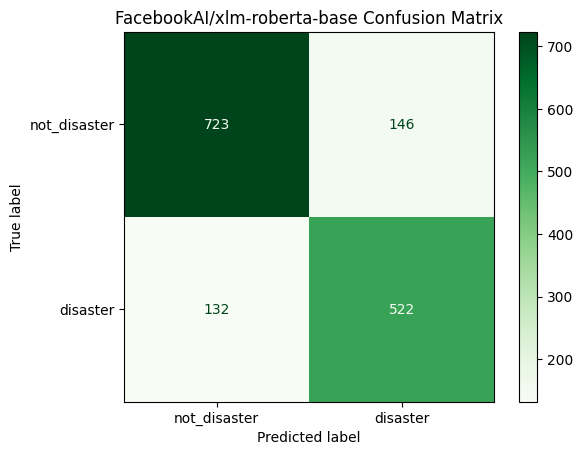

In [60]:
plot_confusion_matrix(confusion_mat, model_name)

## GUI

In [ ]:
import gradio as gr

def text_predict(input):
    return input

def file_predict(input):
    return input

with gr.Blocks() as gui_demo:
    gr.Markdown("Automated Classification of Disaster-Related Tweets")
    with gr.Tab("Text"):
        text_input = gr.Textbox(label= "Input Tweet")
        text_output = gr.Textbox(label = "Prediction")
        text_button = gr.Button("Predict")
    with gr.Tab("File"):
        with gr.Row():
            file_input = gr.File(label= "Input File (as .csv)")
            file_output = gr.Textbox(label = "Prediction")
        file_button = gr.Button("Predict")
    with gr.Tab("API"):
        with gr.Row():
            api_input = gr.Textbox(label= "API Endpoint")
        api_button = gr.Button("Predict")

    text_button.click(text_predict, inputs=text_input, outputs=text_output)
    file_button.click(file_predict, inputs=file_input, outputs=file_output)

gui_demo.launch()


In [7]:
gui_demo.close()

Closing server running on port: 7860
